In [2]:
# PART 0 — Imports and general parameters

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Market proxies:
# ^TNX : US 10-year Treasury yield (rates)
# LQD  : Investment Grade credit
# HYG  : High Yield credit
tickers = ["^TNX", "LQD", "HYG"]

start_date = "2015-01-01"
end_date = None                 # None = up to today

rolling_window = 60             # 60 trading days (~3 months)
quantile_low = 0.05             # lower threshold to define a shock
quantile_high = 0.95            # upper threshold to define a shock

In [3]:
# PART 1 — Data download and cleaning

# Download data from Yahoo Finance
data = yf.download(
    tickers,
    start=start_date,
    end=end_date,
    auto_adjust=True,
    progress=False
)

# Keep only closing prices
# (for multiple tickers, this results in a MultiIndex)
prices = data["Close"].copy()

# Data cleaning:
# - drop rows that are entirely empty
# - forward-fill missing values
prices = prices.dropna(how="all")
prices = prices.ffill()

print("Latest price observations:")
print(prices.tail())

Latest price observations:
Ticker            HYG         LQD   ^TNX
Date                                    
2025-12-24  80.639999  110.650002  4.136
2025-12-26  80.599998  110.639999  4.136
2025-12-29  80.629997  110.790001  4.116
2025-12-30  80.709999  110.660004  4.130
2025-12-31  80.629997  110.190002  4.163


In [4]:
# PART 2 — Return computation

# Daily returns (percentage)
returns = prices.pct_change().dropna()

print("\nDescriptive statistics of returns:")
print(returns.describe().T)


Descriptive statistics of returns:
         count      mean       std       min       25%       50%       75%  \
Ticker                                                                       
HYG     2765.0  0.000186  0.005233 -0.054965 -0.001823  0.000252  0.002270   
LQD     2765.0  0.000121  0.005324 -0.050030 -0.002338  0.000345  0.002678   
^TNX    2765.0  0.000686  0.030062 -0.293201 -0.012494  0.000000  0.012732   

             max  
Ticker            
HYG     0.065460  
LQD     0.073918  
^TNX    0.498998  


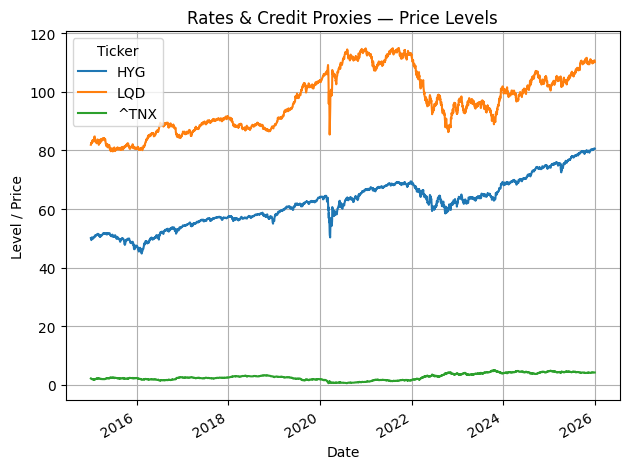

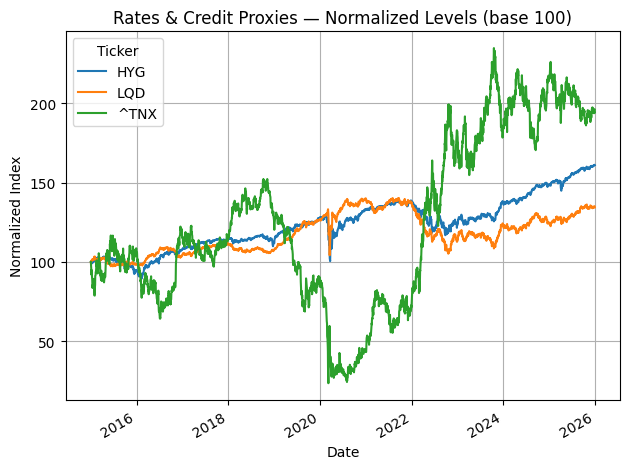

In [5]:
# PART 3 — Price level charts

# 3.1 Raw price levels
prices.plot()
plt.title("Rates & Credit Proxies — Price Levels")
plt.xlabel("Date")
plt.ylabel("Level / Price")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3.2 Normalized price levels (base 100 at inception)
# Allows comparison of dynamics despite different scales
normalized_prices = prices / prices.iloc[0] * 100

normalized_prices.plot()
plt.title("Rates & Credit Proxies — Normalized Levels (base 100)")
plt.xlabel("Date")
plt.ylabel("Normalized Index")
plt.grid(True)
plt.tight_layout()
plt.show()


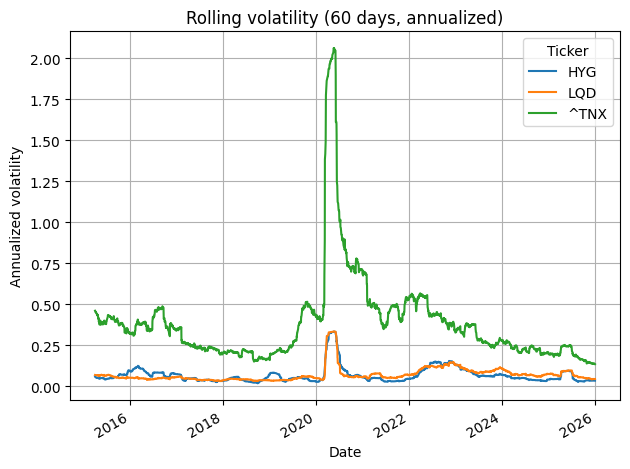


Correlation matrix:
Ticker       HYG       LQD      ^TNX
Ticker                              
HYG     1.000000  0.516739  0.096052
LQD     0.516739  1.000000 -0.534851
^TNX    0.096052 -0.534851  1.000000


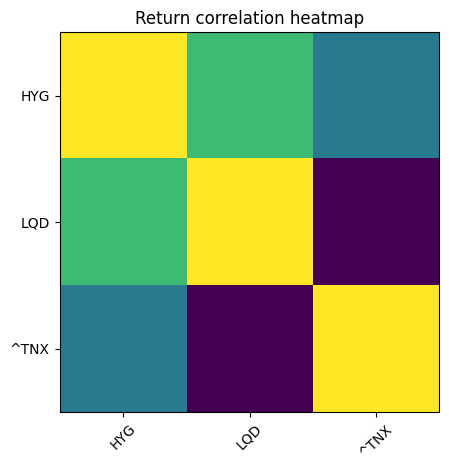

In [6]:
# PART 4 — Rolling volatility and correlation

# Annualized volatility computed over a rolling window
rolling_vol = returns.rolling(rolling_window).std() * np.sqrt(252)

rolling_vol.plot()
plt.title(f"Rolling volatility ({rolling_window} days, annualized)")
plt.xlabel("Date")
plt.ylabel("Annualized volatility")
plt.grid(True)
plt.tight_layout()
plt.show()

# Correlation matrix of returns
corr_matrix = returns.corr()

print("\nCorrelation matrix:")
print(corr_matrix)

# Simple correlation heatmap
plt.imshow(corr_matrix.values)
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
plt.title("Return correlation heatmap")
plt.tight_layout()
plt.show()

In [7]:
# PART 5 — Market shock detection

# Empirical thresholds based on quantiles
quantiles = returns.quantile([quantile_low, quantile_high])

print("\nQuantiles used for shock detection:")
print(quantiles)

# A shock is defined as an extreme return
shock_mask = (
    (returns < quantiles.loc[quantile_low]) |
    (returns > quantiles.loc[quantile_high])
)

# Systemic shock day = at least one asset in shock on that day
system_shock_days = shock_mask.any(axis=1)

print("\nTotal number of systemic shock days:", int(system_shock_days.sum()))


Quantiles used for shock detection:
Ticker       HYG       LQD      ^TNX
0.05   -0.006987 -0.007491 -0.036947
0.95    0.007273  0.006927  0.039401

Total number of systemic shock days: 578


In [8]:
# PART 6 — Summary table

summary_table = pd.DataFrame({
    "average_daily_return": returns.mean(),
    "annualized_volatility": returns.std() * np.sqrt(252),
    "number_of_shock_days": shock_mask.sum(),
    "worst_day": returns.min(),
    "best_day": returns.max(),
})

print("\nSummary table:")
print(summary_table)


Summary table:
        average_daily_return  annualized_volatility  number_of_shock_days  \
Ticker                                                                      
HYG                 0.000186               0.083069                   278   
LQD                 0.000121               0.084517                   278   
^TNX                0.000686               0.477224                   278   

        worst_day  best_day  
Ticker                       
HYG     -0.054965  0.065460  
LQD     -0.050030  0.073918  
^TNX    -0.293201  0.498998  


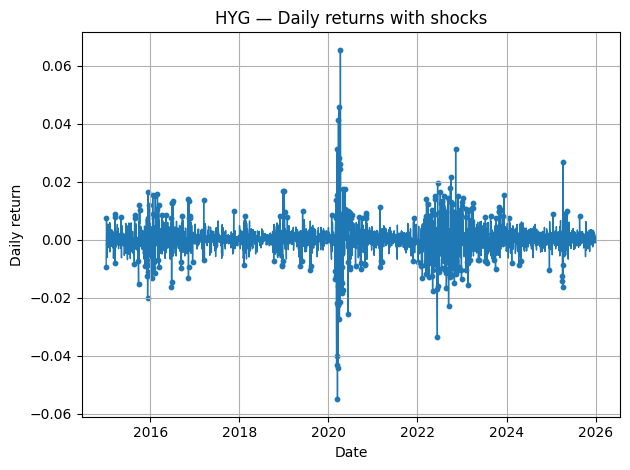

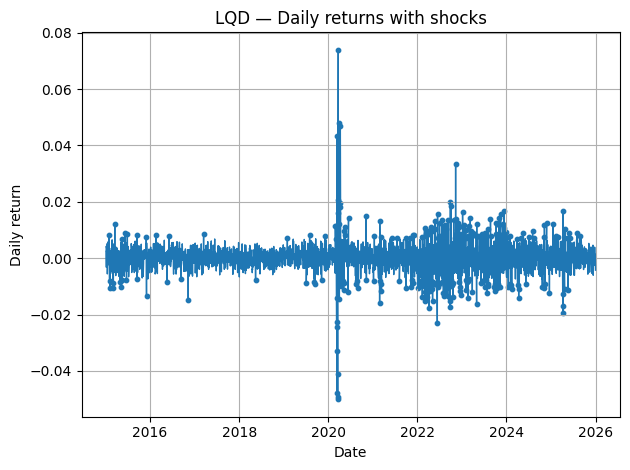

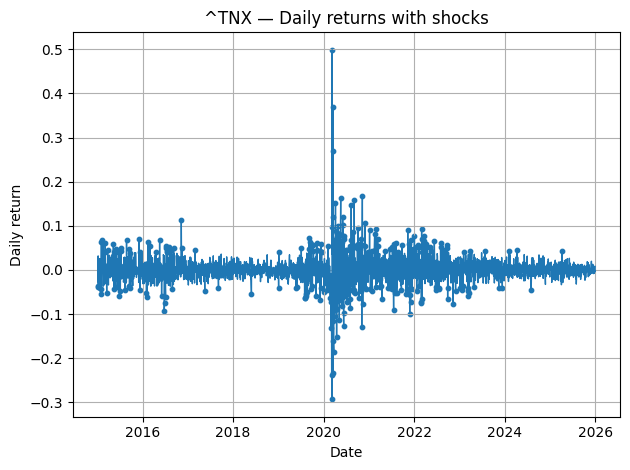

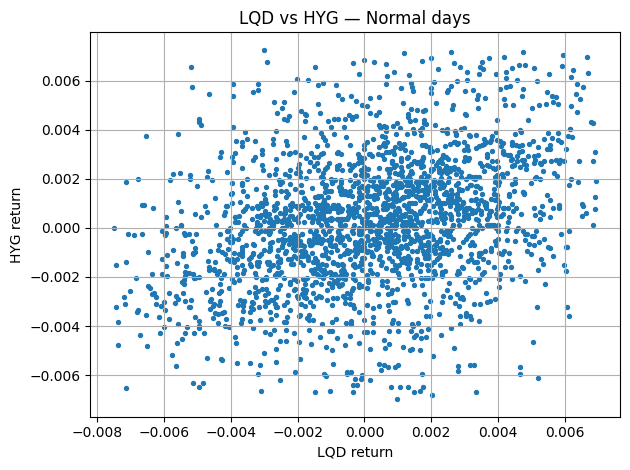

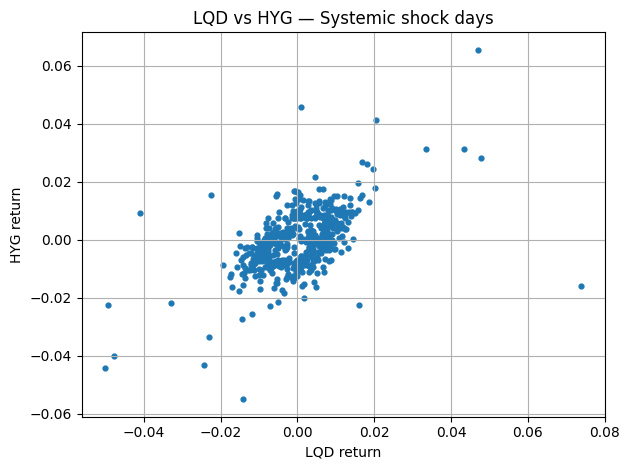

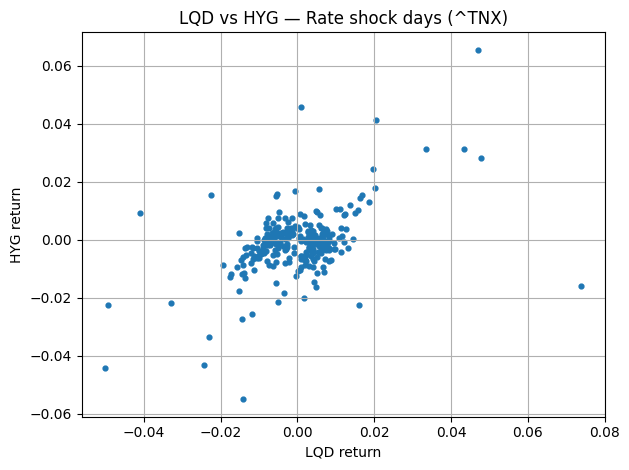

In [9]:
# PART 7 — Shock-focused charts

# 7.1 Daily returns with shock highlighting
for asset in returns.columns:
    plt.figure()
    plt.plot(returns.index, returns[asset], linewidth=1)
    plt.scatter(
        returns.index[shock_mask[asset]],
        returns.loc[shock_mask[asset], asset],
        s=10
    )
    plt.title(f"{asset} — Daily returns with shocks")
    plt.xlabel("Date")
    plt.ylabel("Daily return")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 7.2 LQD vs HYG on normal days
plt.figure()
plt.scatter(
    returns.loc[~system_shock_days, "LQD"],
    returns.loc[~system_shock_days, "HYG"],
    s=8
)
plt.title("LQD vs HYG — Normal days")
plt.xlabel("LQD return")
plt.ylabel("HYG return")
plt.grid(True)
plt.tight_layout()
plt.show()

# 7.3 LQD vs HYG on systemic shock days
plt.figure()
plt.scatter(
    returns.loc[system_shock_days, "LQD"],
    returns.loc[system_shock_days, "HYG"],
    s=12
)
plt.title("LQD vs HYG — Systemic shock days")
plt.xlabel("LQD return")
plt.ylabel("HYG return")
plt.grid(True)
plt.tight_layout()
plt.show()

# 7.4 Focus on rate shocks (^TNX)
tnx_low = returns["^TNX"].quantile(quantile_low)
tnx_high = returns["^TNX"].quantile(quantile_high)

tnx_shock_days = (
    (returns["^TNX"] <= tnx_low) |
    (returns["^TNX"] >= tnx_high)
)

plt.figure()
plt.scatter(
    returns.loc[tnx_shock_days, "LQD"],
    returns.loc[tnx_shock_days, "HYG"],
    s=12
)
plt.title("LQD vs HYG — Rate shock days (^TNX)")
plt.xlabel("LQD return")
plt.ylabel("HYG return")
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:

# PART 8 — Mini “daily report” snapshot

# Extract indicators for the latest available date
last_date = returns.index[-1]

daily_snapshot = pd.DataFrame({
    "last_return": returns.loc[last_date],
    "rolling_annualized_volatility": rolling_vol.loc[last_date],
    "shock_today": shock_mask.loc[last_date],
})

print("\nSnapshot for the latest day:", last_date.date())
print(daily_snapshot)


Snapshot for the latest day: 2025-12-31
        last_return  rolling_annualized_volatility  shock_today
Ticker                                                         
HYG       -0.000991                       0.034637        False
LQD       -0.004247                       0.044685        False
^TNX       0.007990                       0.135583        False
